In [1]:
%load_ext rpy2.ipython
import rpy2.robjects.lib.ggplot2 as ggplot2
import childespy
import numpy as np
import os
import imp
import pandas as pd
import transformers
import torch
import re
import unicodedata
import scipy.stats
import copy
from string import punctuation

# 1 Find Communicative Successes and Failures 

In [2]:
# Communicative success: how many no-xxx, no-yyy child  utterances are in Providence? 
# Communicative failures: how many one-yyy, no-xxx child utterances are in Providence?
# Subset to instances that are monosyllabic later

In [3]:
pvd_idx = childespy.get_sql_query('select * from corpus where name = "Providence"').iloc[0]['id']

R[write to console]: Using current database version: '2020.1'.



In [4]:
phono_glosses = childespy.get_sql_query('select gloss, target_child_name, target_child_age, \
    speaker_code, actual_phonology, model_phonology, transcript_id, utterance_id, \
    token_order, corpus_name, collection_name, language from token where \
    actual_phonology != "" and model_phonology != "" and collection_name = "Eng-NA" \
    and corpus_id = '+str(pvd_idx) ,
        db_version = "2020.1")

R[write to console]: Using supported database version: '2020.1'.



In [5]:
phono_glosses.corpus_name.value_counts()

Providence    396621
Name: corpus_name, dtype: int64

In [6]:
phono_glosses.loc[phono_glosses.gloss == 'xxx'].actual_phonology.value_counts()

*       26736
ə          10
(.)         7
aɪ          4
hiɡh        2
        ...  
ɛs          1
kjɛ         1
hɛʔ         1
dɪs         1
əno         1
Name: actual_phonology, Length: 76, dtype: int64

Actual phonology is almost always * for xxx items

In [7]:
phono_glosses.loc[phono_glosses.gloss == 'yyy'].actual_phonology.value_counts()

ɛ               3206
ʌ               2132
ɪ               1881
ə                512
o                507
                ... 
heɪmɑ              1
dʌzːju             1
ɡiləlidəlɪʊl       1
jʊkwæk             1
ðɪdn̩              1
Name: actual_phonology, Length: 30293, dtype: int64

Actual phonology is populated for yyy items

In [8]:
chi_phono = phono_glosses.loc[(phono_glosses.speaker_code == 'CHI') & 
    (phono_glosses.target_child_age < (365*5))]

In [9]:
def count_transmission_errors(utt_vector, error_codes):
    return(np.sum([x in error_codes for x in  utt_vector]))

In [10]:
xxxs_per_utt = chi_phono.groupby('utterance_id').gloss.agg(
    lambda x: count_transmission_errors(x, ['xxx'])).reset_index()
xxxs_per_utt.columns = ['utterance_id', 'num_xxx']
yyys_per_utt = chi_phono.groupby('utterance_id').gloss.agg(
    lambda x: count_transmission_errors(x, ['yyy'])).reset_index()
yyys_per_utt.columns = ['utterance_id', 'num_yyy']
failures_per_utt = xxxs_per_utt.merge(yyys_per_utt)

In [11]:
yyy_utts = failures_per_utt.loc[(failures_per_utt.num_xxx == 0) &  (failures_per_utt.num_yyy == 1)]

In [12]:
yyy_utts.shape

(31457, 3)

In [13]:
success_utts = failures_per_utt.loc[(failures_per_utt.num_xxx == 0) &  
    (failures_per_utt.num_yyy == 0)]

In [14]:
success_utts.shape

(83880, 3)

In [15]:
tokens_from_errorless_utts = chi_phono.loc[chi_phono.utterance_id.isin(success_utts.utterance_id)]

In [16]:
#exclude un-transcribed tokens and syllabically transcribed tokens
excludes = ['*','(.)','(..)', '(...)','(....)','(.....)']
tokens_from_errorless_utts = tokens_from_errorless_utts.loc[~(tokens_from_errorless_utts.actual_phonology.isin(excludes) |
    tokens_from_errorless_utts.model_phonology.isin(excludes))]

In [17]:
tokens_from_errorless_utts.shape

(214239, 12)

In [18]:
# example phonology
tokens_from_errorless_utts.actual_phonology

1          ɑmɪ
3          wiː
4          wiː
5           uː
52           ɛ
          ... 
396606       o
396607     waɪ
396608     liʔ
396609       ɪ
396610    hɪpo
Name: actual_phonology, Length: 214239, dtype: object

In [19]:
# 31,457 transmission errors (from 31,457 utterances)
# 214,239 transmission successes (from 83,880 utterances)
# this will be further decreased later by the need to test monosyllabic forms

# 2 Prevalence of communication failures by age 

In [20]:
chi_phono = chi_phono.loc[chi_phono.gloss != "xxx"]
chi_phono.shape

(369789, 12)

In [21]:
error_codes = ('yyy')

In [22]:
chi_phono['target_child_age_months'] = chi_phono.target_child_age / 30.5

In [23]:
error_prop_per_transcript = chi_phono.groupby('transcript_id').gloss.agg(lambda x:
        sum(np.array([y in error_codes for y in x]) / len(x))).reset_index()
error_prop_per_transcript.columns = ['transcript_id', 'proportion_errors']
age_per_transcript = chi_phono.groupby('transcript_id').target_child_age_months.agg(np.unique).reset_index()                    
tokens_per_transcript = chi_phono.groupby('transcript_id').target_child_age_months.agg(np.size).reset_index()                    
tokens_per_transcript.columns = ['transcript_id', 'num_tokens']
corpusname_for_transcript = chi_phono.groupby('transcript_id').corpus_name.agg(np.unique).reset_index()
error_prop_per_transcript = error_prop_per_transcript.merge(age_per_transcript).merge(
    tokens_per_transcript).merge(corpusname_for_transcript)
error_prop_per_transcript.head(5)
%R -i error_prop_per_transcript

In [24]:
error_prop_per_transcript.columns

Index(['transcript_id', 'proportion_errors', 'target_child_age_months',
       'num_tokens', 'corpus_name'],
      dtype='object')

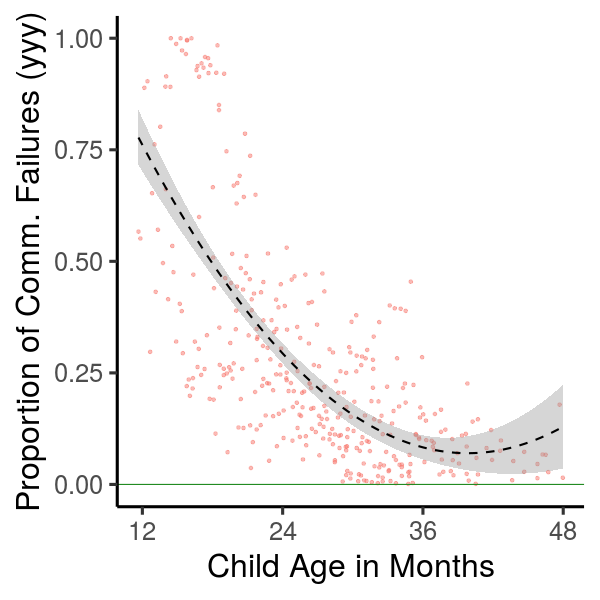

In [25]:
%%R -w 600 -h 600

pvd_comm_error = subset(error_prop_per_transcript,target_child_age_months < 48
    & num_tokens > 20 & corpus_name == 'Providence')

pvd_comm_error$age_in_months = pvd_comm_error$target_child_age / 30.5
year_intervals_in_months = c(12,24,36,48)

ggplot(pvd_comm_error) + geom_point(aes(x=target_child_age_months, 
y=proportion_errors, color= "collection_name"), alpha=.5) + theme_classic(base_size =32) + xlab('Child Age in Months') + ylab(
'Proportion of Comm. Failures (yyy)') + stat_smooth(
aes(x=target_child_age_months,  y=proportion_errors),  linetype='dashed', formula=y ~ poly(
    x, 2, raw=TRUE), method='lm', color='black')  + scale_x_continuous(
    breaks = year_intervals_in_months, labels=year_intervals_in_months) + geom_hline(yintercept=0,
    color = "forestgreen") +theme(legend.position="none")

In [26]:
%%R
# Data for Lvenshtin distances in Providence comes from notebook "Levenshtein distance in Providence"
chi_levdist = read.csv('csv/pvd_levdist.csv')

R[write to console]: Error in file(file, "rt") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In file(file, "rt") :
R[write to console]: 
 
R[write to console]:  cannot open file 'csv/pvd_levdist.csv': No such file or directory




Error in file(file, "rt") : cannot open the connection


In [27]:
%%R -h 600 -w 600
chi_levdist$age_in_months = chi_levdist$target_child_age / 30.5
year_intervals_in_months = c(12,24,36,48)

p1 = ggplot(subset(chi_levdist, mean_levdist < 100 & corpus_name == 'Providence')) + geom_point(aes(x=age_in_months, y=mean_levdist, 
color=collection_name), alpha=.5)  + theme_classic(base_size = 32) +theme(legend.position="none"
) + geom_smooth(aes(x=age_in_months, y=mean_levdist), linetype='dashed', formula=y ~ poly(
    x, 2, raw=TRUE), method='lm', color='black') + ylab("Articulation Error"
) + xlab('Child Age (Months)') + scale_x_continuous(
    breaks = year_intervals_in_months, labels=year_intervals_in_months
)
print(p1)

R[write to console]: Error in withVisible({ : object 'chi_levdist' not found




Error in withVisible({ : object 'chi_levdist' not found


In [28]:
%%R
chi_levdist$age_in_months = NULL
pvd_comm_error_merged = merge(pvd_comm_error, chi_levdist,
        by=c('transcript_id'))
nrow(pvd_comm_error_merged)

R[write to console]: Error in chi_levdist$age_in_months = NULL : 
  object 'chi_levdist' not found




Error in chi_levdist$age_in_months = NULL : 
  object 'chi_levdist' not found


In [29]:
%%R -w 600 -h 600
names(pvd_comm_error_merged)

p1 = ggplot(pvd_comm_error_merged) + geom_point(aes(x=mean_levdist, y=proportion_errors, 
color=age_in_months), alpha=.5)  + theme_classic(base_size = 32
)  + coord_cartesian(ylim=c(0,1), xlim =c(0,1)) + scale_color_viridis_c(
) + ylab('Proportion of Comm. Failures (yyy)') + xlab('Articulation Error'
) + theme(legend.position=c(.3, .7), legend.background=element_blank()) + labs(color = "Age in Months") 

print(p1)


R[write to console]: Error in withVisible({ : object 'pvd_comm_error_merged' not found




Error in withVisible({ : object 'pvd_comm_error_merged' not found


In [30]:
error_prop_per_transcript.loc[(error_prop_per_transcript.target_child_age_months < 24)
    & (error_prop_per_transcript.proportion_errors > .95) &  (error_prop_per_transcript.num_tokens > 20)]

,transcript_id,proportion_errors,target_child_age_months,num_tokens,corpus_name
1,42205,0.957921,17.358607,404.0,Providence
3,42207,0.984102,18.422131,629.0,Providence
105,42309,0.987261,14.889344,628.0,Providence
106,42310,0.964646,15.723361,594.0,Providence
107,42311,0.972692,15.395492,769.0,Providence
108,42312,0.995117,15.821721,1024.0,Providence
270,42474,1.000000,14.430328,171.0,Providence
271,42475,1.000000,15.264344,265.0,Providence
272,42476,0.996212,15.821721,264.0,Providence
273,42477,1.000000,16.196721,68.0,Providence


In [31]:
# Manually confirm that these transcripts indeed have a very high proportion of errors
# Yep!

# 3 Load BERT Models + CMU Dict

### Get the CMU Pronunciation Dictionary

In [32]:
cmu_in_childes = pd.read_csv('phon/cmu_in_childes.csv')
cmu_2syl_inchildes = cmu_in_childes.loc[cmu_in_childes.num_vowels <=2]

### BERT models

In [33]:
from pytorch_pretrained_bert import BertForMaskedLM
from transformers import BertTokenizer # DO NOT load the one from pytorch_pretrained_bert;
# it does not support adding new vocabulary

import transfomers_bert_completions
imp.reload(transfomers_bert_completions)

<module 'transfomers_bert_completions' from '/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/transfomers_bert_completions.py'>

# 4 Prep Utterances / Tokens for BERT

** IMPORTANT **

Eval = for age, all splits. This is PROVIDENCE:
for Child -> this is the 400 PER CHILD, not all of Providence!

In [45]:
# Get the index of the Providence corpus
pvd_idx = childespy.get_sql_query('select * from corpus where name = "Providence"').iloc[0]['id']

R[write to console]: Using current database version: '2020.1'.



In [109]:
# Load utterances from the Providence corpus from childs-db
regenerate = True
if regenerate:
    utt_glosses = childespy.get_sql_query('select gloss, transcript_id, id, \
    utterance_order, speaker_code, target_child_name, target_child_age, type from utterance where corpus_id = '+str(pvd_idx) ,
        db_version = "2020.1")
    utt_glosses.to_csv('csv/pvd_utt_glosses.csv', index=False)
else: 
    utt_glosses = pd.read_csv('csv/pvd_utt_glosses.csv')

R[write to console]: Using supported database version: '2020.1'.



In [47]:
# Prep the utterances for tokenization

# make compound words single words
def fix_gloss(gloss):
    # migt be better to split these glosses (black+bird -> black bird),but then we lose the alignment 
    return(str(gloss).replace('+','').replace('_',''))
utt_glosses.gloss = [fix_gloss(x) for x in utt_glosses.gloss]

# add back punctuation from the utterance type
punct_for_type = {
    'question':'?',
    'declarative':'.',
    'self interruption':'.',
    'interruption':'!',
    'trail off':'...',
    'interruption question':'?',
    'trail off question':'?',
    'imperative_emphatic':'!' 
}
utt_glosses['punct'] = [punct_for_type[x] if x in punct_for_type else '.'
                        for x in utt_glosses.type ]

# add the speaker code (for compatibility with a fine-tuned model that has speaker identity)
utt_glosses = utt_glosses.loc[[x is not None for x in utt_glosses.punct]]
utt_glosses['speaker_code_simple'] = ['[CHI]' if x == 'CHI' else '[CGV]'
    for x in utt_glosses.speaker_code]

# build a single form that is appropriate for running through the tokenizer
utt_glosses['gloss_with_punct'] = [x['speaker_code_simple'] +' '+ x['gloss'].lower()+ x['punct'] for x in utt_glosses.to_dict('records')] 
utt_glosses.shape

(460061, 9)

In [48]:
utt_glosses[utt_glosses.id == 17280964]

,gloss,transcript_id,id,utterance_order,speaker_code,type,punct,speaker_code_simple,gloss_with_punct
460056,oh why lick hippo,42569,17280964,756,CHI,self interruption,.,[CHI],[CHI] oh why lick hippo.


### Build the Vocabulary

In [49]:
# tokenize with the most extensive tokenizer, which is the one used for model #2

initial_tokenizer = BertTokenizer.from_pretrained('model_output2')
initial_tokenizer.add_tokens(['yyy','xxx']) #must maintain xxx and yyy for alignment,
# otherwwise, BERT tokenizer will try to separate these into x #x and #x and y #y #y
inital_vocab_mask, initial_vocab = transfomers_bert_completions.get_softmax_mask(initial_tokenizer,
    cmu_2syl_inchildes.word)

In [50]:
# confirm yyy treated as a separate character
initial_tokenizer.tokenize('this is a yyy.')

['this', 'is', 'a', 'yyy', '.']

In [51]:
cmu_in_initial_vocab = cmu_2syl_inchildes.loc[cmu_2syl_inchildes.word.isin(initial_vocab)]
cmu_in_initial_vocab.shape

(7904, 8)

In [52]:
# build a dataframe of tokens 
# this is slow, because tokenization is slow
def inflate (row):
    tokens = initial_tokenizer.tokenize(row['gloss_with_punct'])
    return(pd.DataFrame({'token':tokens, 'id':row['id']}) )

regenerate = True
if regenerate:
    all_tokens = pd.concat([inflate(x) for x in utt_glosses.to_dict('records')])
    all_tokens = all_tokens.merge(utt_glosses)
    all_tokens.to_csv('csv/pvd_utt_glosses_inflated.csv')

else:
    all_tokens = pd.read_csv('csv/pvd_utt_glosses_inflated.csv', na_filter=False)

In [53]:
all_tokens.iloc[0:10]

,token,id,gloss,transcript_id,utterance_order,speaker_code,type,punct,speaker_code_simple,gloss_with_punct
0,[cgv],16759250,where do you want me to go,42204,1,OPE,question,?,[CGV],[CGV] where do you want me to go?
1,where,16759250,where do you want me to go,42204,1,OPE,question,?,[CGV],[CGV] where do you want me to go?
2,do,16759250,where do you want me to go,42204,1,OPE,question,?,[CGV],[CGV] where do you want me to go?
3,you,16759250,where do you want me to go,42204,1,OPE,question,?,[CGV],[CGV] where do you want me to go?
4,want,16759250,where do you want me to go,42204,1,OPE,question,?,[CGV],[CGV] where do you want me to go?
5,me,16759250,where do you want me to go,42204,1,OPE,question,?,[CGV],[CGV] where do you want me to go?
6,to,16759250,where do you want me to go,42204,1,OPE,question,?,[CGV],[CGV] where do you want me to go?
7,go,16759250,where do you want me to go,42204,1,OPE,question,?,[CGV],[CGV] where do you want me to go?
8,?,16759250,where do you want me to go,42204,1,OPE,question,?,[CGV],[CGV] where do you want me to go?
9,[cgv],16759261,anywhere you'll feel comfortable um anywhere,42204,2,MOT,declarative,.,[CGV],[CGV] anywhere you'll feel comfortable um anyw...


In [54]:
# Assign a token_id (integer in the BERT vocabulary). 
# Because these are from the tokenized utterances, there is no correpsondence 
# with childes-db token ids
all_tokens['token_id'] = initial_tokenizer.convert_tokens_to_ids(all_tokens['token'])
# assigns utterances a 0-indexed index column
all_tokens['seq_utt_id'] = all_tokens['id'].astype('category').cat.codes

### Add back IPA, syllable structure, and child ages for child productions

In [55]:
# get the token-level data, esp phonology
regenerate = True
if regenerate:

    # get token-level information for Providence
    pvd_chi_tokens = childespy.get_sql_query('select gloss, target_child_name, target_child_age, \
    speaker_code, actual_phonology, model_phonology, transcript_id, utterance_id, \
    token_order from token where speaker_code = "CHI" and corpus_id = '+str(pvd_idx),
        db_version = "2020.1")
    pvd_chi_tokens['gloss'] = [fix_gloss(x) for x in pvd_chi_tokens.gloss]
    
    # prep the tokens generated from segmenting the utterances
    all_tokens_test = copy.deepcopy(all_tokens) 

    # initialize the fields that need to be populated
    all_tokens_test['actual_phonology'] = ''
    all_tokens_test['model_phonology'] = ''
    all_tokens_test['target_child_age'] = np.nan
    
    # get a set of unique utterances
    _, idx = np.unique(all_tokens_test.id, return_index=True)
    all_utt_indices = all_tokens_test.id[np.sort(idx)]
    
    # For fast retrieval of IPA, split pvd_chi_tokens into a dictionary
    pvd_chi_tokens_list = pvd_chi_tokens.groupby(['utterance_id'])
    pvd_chi_tokens_dict = dict(zip(
        [x[0] for x in pvd_chi_tokens_list], 
        [x[1] for x in pvd_chi_tokens_list], 
    ))
    
    # For fast retrival of BERT tokenization
    all_tokens_test_list = all_tokens_test.groupby(['id'])
    all_tokens_test_dict = dict(zip(
        [x[0] for x in all_tokens_test_list], 
        [x[1] for x in all_tokens_test_list], 
    ))
        
    # Augment the tokens from all_tokens with the IPA from pvd_chi_tokens 
    rvs = [] 
    utts_to_retrieve = yyy_utts.utterance_id.to_list() + success_utts.utterance_id.to_list()
    i=-1
    for utt_index in all_utt_indices: #utts_to_retrieve: #[16760331]:       
        i+=1
        if i % int(len(all_utt_indices) / 100) == 0:
            print(str(np.round((i / (len(all_utt_indices)) * 100),2))+'% complete...')    
            # should learn to use tqdm instead
        if utt_index in utts_to_retrieve:        
            utt_df = copy.deepcopy(all_tokens_test_dict[utt_index])
            utt_df['model_phonology'] = transfomers_bert_completions.augment_with_ipa(
              utt_df, pvd_chi_tokens_dict[utt_index],initial_tokenizer, 'model_phonology')
            utt_df['actual_phonology'] = transfomers_bert_completions.augment_with_ipa(
              utt_df, pvd_chi_tokens_dict[utt_index],initial_tokenizer, 'actual_phonology')
            utt_df['target_child_age'] = pvd_chi_tokens_dict[utt_index].iloc[0].target_child_age    
            rvs.append(utt_df)  
        else:
            rvs.append(all_tokens_test_dict[utt_index])  
            
    # get the resulting augmented forms back into a dataframe
    all_tokens_phono = pd.concat(rvs)
    
    # add a unique identifier to the BERT tokens
    all_tokens_phono['bert_token_id'] = range(all_tokens_phono.shape[0])
    
    #save the results
    all_tokens_phono.to_pickle('csv/pvd_utt_glosses_phono_inflated.pkl')
else:
    all_tokens_phono = pd.read_pickle('csv/pvd_utt_glosses_phono_inflated.pkl')

R[write to console]: Using supported database version: '2020.1'.



0.0% complete...


/home/nwong/chompsky/childes/child_listening_continuation/child-listening-env/lib/python3.7/site-packages/pandas/core/frame.py:1554: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  FutureWarning,


1.0% complete...
2.0% complete...
3.0% complete...
4.0% complete...
5.0% complete...
6.0% complete...
7.0% complete...
8.0% complete...
9.0% complete...
10.0% complete...
11.0% complete...
12.0% complete...
13.0% complete...
14.0% complete...
15.0% complete...
16.0% complete...
17.0% complete...
18.0% complete...
19.0% complete...
20.0% complete...
21.0% complete...
22.0% complete...
23.0% complete...
24.0% complete...
25.0% complete...
26.0% complete...
27.0% complete...
28.0% complete...
29.0% complete...
30.0% complete...
31.0% complete...
32.0% complete...
33.0% complete...
34.0% complete...
35.0% complete...
36.0% complete...
37.0% complete...
37.99% complete...
38.99% complete...
39.99% complete...
40.99% complete...
41.99% complete...
42.99% complete...
43.99% complete...
44.99% complete...
45.99% complete...
46.99% complete...
47.99% complete...
48.99% complete...
49.99% complete...
50.99% complete...
51.99% complete...
52.99% complete...
53.99% complete...
54.99% complete...
5

In [56]:
# Inspect the IPA
all_tokens_phono.loc[all_tokens_phono.actual_phonology != ''][['token','actual_phonology','model_phonology']]

,token,actual_phonology,model_phonology
42,mommy,ɑmɪ,mɑmiː
81,yyy,ʌ,*
170,wee,wiː,wiː
173,yyy,aʊ,*
201,wee,wiː,wiː
...,...,...,...
3083590,nobody,nobɑɾi,noʊbɑdiː
3083591,hates,heɪs,heɪts
3083596,oh,o,oʊ
3083597,why,waɪ,waɪ


In [57]:
# Get the IPA map
phone_map_df = pd.read_csv('phon/phon_map_populated.csv')
phone_map_df.head()

,arpa,ipa,c_or_v
0,AA,ɑ,v
1,AE,æ,v
2,AH,ə,v
3,AO,ɔ,v
4,AW,aʊ,v


In [58]:
def phone_remap(x):
    return(x.replace("ː","").replace('ʌ','ə')
.replace('ɪ','ə').replace('ɔ','ɑ').replace('a','ɑ').replace('o','oʊ').replace('˞','').replace('ʰ',
    ''). replace('r','ɹ')).replace('\\^','').replace('\\ ̃','').replace(' ̩','').replace('^',''
).replace('ʙ','b').replace('(','').replace(')','').replace('.','').replace('ch','ʧ'
).replace('c','k').replace('g','ɡ').replace('y','j').replace('ʁ','ɹ')

def strip_accents(string, accents=('COMBINING ACUTE ACCENT', 
    'COMBINING GRAVE ACCENT', 'COMBINING TILDE', 'COMBINING VERTICAL LINE BELOW',
    'COMBINING SHORT STROKE OVERLAY')):
    accents = set(map(unicodedata.lookup, accents))
    chars = [c for c in unicodedata.normalize('NFD', string) if c not in accents]
    return unicodedata.normalize('NFC', ''.join(chars))

cv_map = dict(zip(phone_map_df['ipa'], phone_map_df['c_or_v']))
cv_map['o'] = 'v' 
cv_map['ɜ'] = 'v'
cv_map['e'] = 'v'
cv_map['ʔ'] = 'c'
cv_map['ɾ'] = 'c'
cv_map['ɲ'] = 'c'
cv_map['x'] = 'c'
cv_map['ɱ'] = 'c'
cv_map['ɣ'] = 'c'

def cv_mapper(x, cv_map):
    try:
        return(cv_map[x])
    except:
        raise ValueError(x)

regenerate = True
if regenerate:    

    # Do the same excludes as were used to identify appropriate utterances
    excludes = ['*','(.)','(..)', '(...)','(....)','(.....)']
    all_tokens_phono.loc[all_tokens_phono.actual_phonology.isin(excludes),'actual_phonology'] =''
    all_tokens_phono.loc[all_tokens_phono.actual_phonology.str.contains('V'),'actual_phonology'] =''
    
    # remap phonology from narrow phonetic transcription to broad phonological transcription
    all_tokens_phono['model_phonology_clean'] = [phone_remap(x) for x in all_tokens_phono['model_phonology']]
    all_tokens_phono['actual_phonology_clean'] = [phone_remap(x) for x in all_tokens_phono['actual_phonology']]

    # remove any non-combining diacritical marks
    all_tokens_phono['model_phonology_no_dia'] = [strip_accents(x) for x in \
    all_tokens_phono['model_phonology_clean']]
    all_tokens_phono['actual_phonology_no_dia'] = [strip_accents(x) for x in \
    all_tokens_phono['actual_phonology_clean']]
    
    # Compute the number of non-contiguous vowels.
    # slightly different than the cmu vowel computation ---
    # because here we are computing it directly from IPA
    all_tokens_phono['cv_raw'] = [''.join([cv_mapper(x, cv_map) for x in list(y)]) if y != '' else '' for y in all_tokens_phono['actual_phonology_no_dia']]    
    all_tokens_phono['cv_collapsed']  = [re.sub(r'(.)\1+', r'\1', str(x)) if x != '' else '' for x in all_tokens_phono['cv_raw']]
    all_tokens_phono['num_vowels'] = [np.sum(np.array(list(x)) == 'v') if x !='' else np.nan for x in all_tokens_phono['cv_collapsed']]
    all_tokens_phono.to_pickle('csv/pvd_utt_glosses_phono_cleaned_inflated.pkl')
else:
    all_tokens_phono = pd.read_pickle('csv/pvd_utt_glosses_phono_cleaned_inflated.pkl')


In [59]:
all_tokens_phono.loc[all_tokens_phono.actual_phonology_no_dia != '']['actual_phonology_no_dia']

42             ɑmə
81               ə
170             wi
173             ɑʊ
201             wi
            ...   
3083590    noʊbɑɾi
3083591       heəs
3083596         oʊ
3083597        wɑə
3083598        liʔ
Name: actual_phonology_no_dia, Length: 254440, dtype: object

In [60]:
all_tokens_phono.shape

(3083627, 23)

In [115]:
all_tokens_phono.iloc[0] # it's not a success token -- what is the meaning of success token vs utterance?

token                                                  [cgv]
id                                                  16759250
gloss                             where do you want me to go
transcript_id                                          42204
utterance_order                                            1
speaker_code                                             OPE
type                                                question
punct                                                      ?
speaker_code_simple                                    [CGV]
gloss_with_punct           [CGV] where do you want me to go?
token_id                                               30523
seq_utt_id                                                 0
actual_phonology                                            
model_phonology                                             
target_child_age                                         NaN
bert_token_id                                              0
model_phonology_clean   

### Identify the tokens that can be evaluated 

In [61]:
# find the tokens in the resulting dataframe that belong to the utterances identified above

In [62]:
initial_vocab

array(['a', 'b', 'c', ..., 'hideout', 'pudding', 'stalks'], dtype='<U18')

In [63]:
successful_utt_ids = set(success_utts['utterance_id'])
initial_vocab_set = set(initial_vocab)
yyy_utt_ids = set(yyy_utts['utterance_id'])
all_tokens_phono['in_vocab'] = all_tokens_phono['token'].isin(initial_vocab_set)
all_tokens_phono['success_token'] = [x in successful_utt_ids for x in 
    all_tokens_phono['id']]
all_tokens_phono['yyy_token'] = [x in yyy_utt_ids for x in 
    all_tokens_phono['id']]

In [64]:
all_tokens_phono.shape

(3083627, 26)

### Identify the subset of success and failure utterances that have transcriptions

In [65]:
all_tokens_phono['partition'] = 'none'

In [66]:
success_tokens = all_tokens_phono.loc[(all_tokens_phono['success_token']) & 
    (all_tokens_phono['num_vowels'] <= 2) ]
all_tokens_phono.loc[(all_tokens_phono['success_token']) & 
    (all_tokens_phono['num_vowels'] <= 2), 'partition'] = 'success'     
success_tokens.shape

(188212, 27)

In [67]:
all_tokens_phono.loc[(all_tokens_phono['success_token']) & 
    (all_tokens_phono['num_vowels'] <= 2)]

,token,id,gloss,transcript_id,utterance_order,speaker_code,type,punct,speaker_code_simple,gloss_with_punct,...,actual_phonology_clean,model_phonology_no_dia,actual_phonology_no_dia,cv_raw,cv_collapsed,num_vowels,in_vocab,success_token,yyy_token,partition
42,mommy,16759315,Mommy,42204,6,CHI,declarative,.,[CHI],[CHI] mommy.,...,ɑmə,mɑmi,ɑmə,vcv,vcv,2.0,True,True,False,success
170,wee,16759467,wee,42204,24,CHI,declarative,.,[CHI],[CHI] wee.,...,wi,wi,wi,cv,cv,1.0,True,True,False,success
201,wee,16759501,wee,42204,28,CHI,declarative,.,[CHI],[CHI] wee.,...,wi,wi,wi,cv,cv,1.0,True,True,False,success
239,woo,16759549,woo,42204,33,CHI,declarative,.,[CHI],[CHI] woo.,...,u,wu,u,v,v,1.0,True,True,False,success
743,ernie,16759752,Ernie,42204,58,CHI,declarative,.,[CHI],[CHI] ernie.,...,ɛ,əɹni,ɛ,v,v,1.0,True,True,False,success
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3083577,help,17280891,help,42569,752,CHI,declarative,.,[CHI],[CHI] help.,...,ɛlp,hɛlp,ɛlp,vcc,vc,1.0,True,True,False,success
3083591,hates,17280946,nobody hates Simba,42569,755,CHI,declarative,.,[CHI],[CHI] nobody hates simba.,...,heəs,heəts,heəs,cvvc,cvc,1.0,True,True,False,success
3083596,oh,17280964,oh why lick hippo,42569,756,CHI,self interruption,.,[CHI],[CHI] oh why lick hippo.,...,oʊ,oʊʊ,oʊ,vv,v,1.0,True,True,False,success
3083597,why,17280964,oh why lick hippo,42569,756,CHI,self interruption,.,[CHI],[CHI] oh why lick hippo.,...,wɑə,wɑə,wɑə,cvv,cv,1.0,True,True,False,success


In [110]:
all_tokens_phono.columns

Index(['token', 'id', 'gloss', 'transcript_id', 'utterance_order',
       'speaker_code', 'type', 'punct', 'speaker_code_simple',
       'gloss_with_punct', 'token_id', 'seq_utt_id', 'actual_phonology',
       'model_phonology', 'target_child_age', 'bert_token_id',
       'model_phonology_clean', 'actual_phonology_clean',
       'model_phonology_no_dia', 'actual_phonology_no_dia', 'cv_raw',
       'cv_collapsed', 'num_vowels', 'in_vocab', 'success_token', 'yyy_token',
       'partition'],
      dtype='object')

In [68]:
yyy_tokens = all_tokens_phono.loc[(all_tokens_phono['yyy_token']) & 
(all_tokens_phono['token'] == 'yyy') & (all_tokens_phono.num_vowels <= 2) ]
all_tokens_phono.loc[(all_tokens_phono['yyy_token']) & 
(all_tokens_phono['token'] == 'yyy') & (all_tokens_phono.num_vowels <= 2),'partition'] = 'yyy'
yyy_tokens.shape

(27693, 27)

In [69]:
all_tokens_phono.partition.value_counts()

none       2867722
success     188212
yyy          27693
Name: partition, dtype: int64

In [70]:
initial_tokenizer.unk_token_id

100

In [71]:
# this adds the partition information
all_tokens_phono.to_pickle('csv/pvd_utt_glosses_phono_cleaned_inflated.pkl')

# (you are here in the refactor! -- this is where Get Providence data ends)


# 5 Model query/evaluations begin here -- this is also where to begin re-running code for replications (previous code will take a long time to run, so load from phono cleaned etc.)

In [80]:
all_tokens_phono.loc[all_tokens_phono.token == 'xxx','token_id'] = initial_tokenizer.unk_token_id
all_tokens_phono.loc[all_tokens_phono.token == 'yyy','token_id'] = initial_tokenizer.unk_token_id

### New models

In [34]:
# New models!

# Need to load from the om2 files -- how to do this? Load this locally at first.
#replication_LM = BertForMaskedLM.from_pretrained('bert-large-uncased')
#replication_LM.eval()
#replication_tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
#replication_softmax_mask, replication_vocab = transfomers_bert_completions.get_softmax_mask(replication_tokenizer, cmu_2syl_inchildes.word)


In [35]:
# Need to load from the om2 files.
#with_tag_LM = BertForMaskedLM.from_pretrained('bert-large-uncased')
#with_tag_LM.eval()
#with_tag_tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')


## 6/17 From Dr. Meylan
##with_tag_tokenizer.add_tokens(['[chi]','[cgv]']) # Need to check this first with the datasets code -> results
## Above: shouldn't be necessary because the tokenizer was saved.

#with_tag_softmax_mask, with_tag_replication_vocab = transfomers_bert_completions.get_softmax_mask(with_tag_tokenizer, cmu_2syl_inchildes.word)


### Old models

In [81]:
# Off-the-shelf model
adult_bertMaskedLM = BertForMaskedLM.from_pretrained('bert-base-uncased')
adult_bertMaskedLM.eval()
adult_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
adult_softmax_mask, adult_vocab = transfomers_bert_completions.get_softmax_mask(adult_tokenizer, cmu_2syl_inchildes.word)

In [82]:
# Fine-tuned model 
# Temporarily local for now
ft1_bertMaskedLM = BertForMaskedLM.from_pretrained('./model_output')
ft1_bertMaskedLM.eval()
ft1_tokenizer = BertTokenizer.from_pretrained('./model_output')
ft1_softmax_mask, ft1_vocab = transfomers_bert_completions.get_softmax_mask(ft1_tokenizer, cmu_2syl_inchildes.word)

# 6 Prevalence of Successes and Failures Across Time

In [83]:
# get number of tokens per age
success_utts['set'] = 'success'
yyy_utts['set'] = 'failure'

/home/nwong/chompsky/childes/child_listening_continuation/child-listening-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/nwong/chompsky/childes/child_listening_continuation/child-listening-env/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [84]:
# get child age in days associated with each utterance id and plot it

In [85]:
utt_age = chi_phono.groupby('utterance_id').target_child_age.agg(np.unique).reset_index()

In [86]:
utts_with_ages = pd.concat([success_utts, yyy_utts]).merge(utt_age)
%R -i utts_with_ages

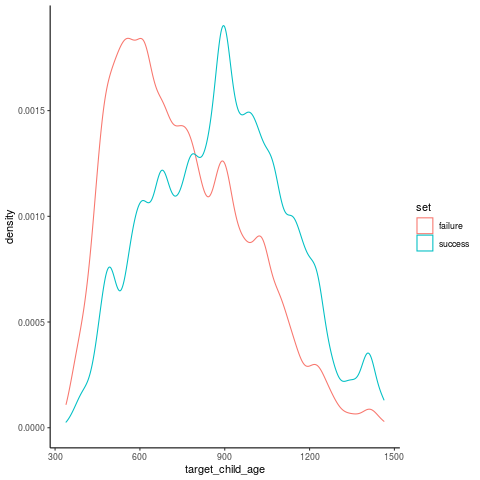

In [87]:
%%R
### Number of utterances by Age
ggplot(utts_with_ages) + geom_density(aes(x=target_child_age, color=set)) + theme_classic()

In [88]:
utts_with_ages['year'] = .5*np.floor(utts_with_ages['target_child_age'] / (365. /2) ) 
print(utts_with_ages.loc[utts_with_ages.set == 'failure'].year.value_counts())
print(utts_with_ages.loc[utts_with_ages.set == 'success'].year.value_counts())

1.5    9919
2.0    7261
1.0    6693
2.5    4895
3.0    2097
3.5     414
0.5     167
4.0      11
Name: year, dtype: int64
2.0    22432
2.5    21194
1.5    16798
3.0    12564
1.0     6697
3.5     3683
4.0      379
0.5      133
Name: year, dtype: int64


# 7 Load a Set of Models

### IMPORTANT NOTE: You should filter the train/val from the child evaluations at this point.

In [ ]:
import load_models
import importlib
importlib.reload(load_models)

In [94]:
models = [
    {
        'title': 'CHILDES BERT no speaker replication, same utt only', 
        'kwargs': load_models.get_all_data_models(with_tags = False).update({'context_width_in_utts' : 0}),
       'type' : 'BERT'
    },
    {
       'title': 'CHILDES BERT, speaker tags, same utt only', 
       'kwargs': load_models.get_all_data_models(with_tags = True).update({'context_width_in_utts' : 0}),
       'type' : 'BERT',
    },
    {
       'title': 'CHILDES BERT no speaker replication, +-20 utts context', 
       'kwargs': load_models.get_all_data_models(with_tags = True).update({'context_width_in_utts' : 20}),
       'type' : 'BERT',
    },
    {'title': 'CHILDES BERT, +-20 utts context',
     'kwargs': {'modelLM': ft1_bertMaskedLM,
                'tokenizer': ft1_tokenizer,
                'softmax_mask': ft1_softmax_mask,
                'context_width_in_utts': 20,
                'use_speaker_labels':False
               },
     'type': 'BERT'
    },
    {'title': 'CHILDES BERT, same utt only',
     'kwargs': {'modelLM': ft1_bertMaskedLM,
                'tokenizer': ft1_tokenizer,
                'softmax_mask': ft1_softmax_mask,
                'context_width_in_utts': 0,
                'use_speaker_labels':False
               },
     'type': 'BERT'
    },
    {'title': 'Adult BERT, +-20 utts context',
    'kwargs': {'modelLM': adult_bertMaskedLM,
                'tokenizer': adult_tokenizer,
                'softmax_mask': adult_softmax_mask,
                'context_width_in_utts': 20,
               'use_speaker_labels':False
               },
     'type': 'BERT'
    },
    {'title': 'Adult BERT, same utt only',
    'kwargs': {'modelLM': adult_bertMaskedLM,
                'tokenizer': adult_tokenizer,
                'softmax_mask': adult_softmax_mask,
                'context_width_in_utts': 0,
               'use_speaker_labels':False
               },
     'type': 'BERT'
    },        
    {'title': 'CHILDES Unigram',
    'kwargs': {'child_counts_path': 'data/chi_vocab.csv',
                'tokenizer': adult_tokenizer,
                'softmax_mask': adult_softmax_mask,
                'vocab': initial_vocab
               },
     'type': 'unigram'
    },
    {'title': 'Flat Unigram',
    'kwargs': {'child_counts_path': None,
                'tokenizer': adult_tokenizer,
                'softmax_mask': adult_softmax_mask,
                'vocab': initial_vocab
               },
     'type': 'unigram'
    }
]

# 8 Find the Best Value of $\beta$

In [95]:
imp.reload(transfomers_bert_completions)

<module 'transfomers_bert_completions' from '/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/transfomers_bert_completions.py'>

You may also want to move this to a py file -- this is pretty slow

You will need to save the arguments somehow?

Here don't try to run R and the Python together -- cache the beta_results and run via tmux, then you can just make the plot a matplotlib plot instead and save it to a folder.

** Success utts should be loaded as eval_utts in the future, because child data evaluates on a subset of success utts. **

In [96]:
# maximize the posterior by iterating over beta values
success_utts_for_beta_fitting = success_utts.sample(1000, replace=False).utterance_id
success_utts_for_beta_fitting

test_beta_vals = np.arange(2.5,3.5,.1)
beta_results = transfomers_bert_completions.sample_across_models(success_utts_for_beta_fitting, success_utts, yyy_utts, 
    all_tokens_phono, models[0:1], initial_vocab, cmu_in_initial_vocab, beta_values =
                     test_beta_vals)

beta_results_surp = beta_results.groupby(['beta_value']).posterior_surprisal.agg(lambda x: np.mean(-1 * np.log(x))
).reset_index()
%R -i beta_results_surp

Running model CHILDES BERT, +-20 utts context...
Computing failure scores
Computing success scores


In [97]:
# something wrong with model feeding for successful utterances
# this has chi in the dataset -- IIRC it should always be there, just it is not always used
# the id is repeated across multiple token records. Is this the same as success_id? 
# this seems like it has something to do with the retrival of context

/home/nwong/chompsky/childes/child_listening_continuation/child-listening-env/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


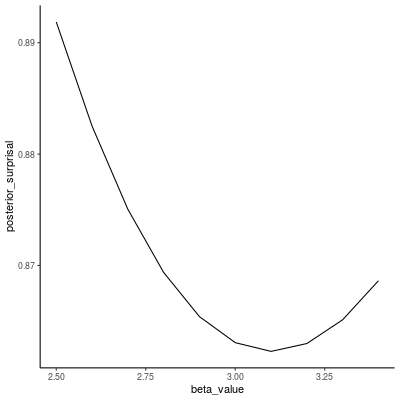

In [98]:
%%R -w 400 -h 400
# I think this is just standard python plotting
ggplot(beta_results_surp) + geom_line(aes(x=beta_value, y=posterior_surprisal)) + theme_classic()

You will want to save the beta values here eventually for use in optimizing children speech

## Caching all values that are used for run models across time

In [ ]:
cache_path = './models_across_time_values'

values_to_cache = [utts_with_ages, all_tokens_phono, initial_vocab, cmu_in_initial_vocab]
values_names = ['utts_with_ages.csv', 'all_tokens_phono.csv', 'initial_vocab.csv', 'cmu_in_initial_vocab.csv']

print('TO DO: Check these inputs for various dependencies in terms of the split themselves.')
for this_name, this_value in zip(values_names, values_to_cache):
    this_value.to_csv(os.path.join(cache_path, this_name))

utts_with_ages.to_csv(os.path.join(cache_path, 'utts_with_ages.csv'))
all_tokens_phono.to_csv(os.path.join(cache_path, 'all_tokens_phono.csv'))
initial_vocab.to_csv(os.path.join(cache_path, 'initial_vocab.csv'))
cmu_in_initial_vocab.to_csv(os.path.join(cache_path, 'cmu_in_initial_vocab.csv'))



# 9 Run Models Across Time

In [ ]:
# Load the cached values

utts_with_ages = pd.read_csv(os.path.join(cache_path, 'utts_with_ages'))
all_tokens_phono = pd.read_csv(os.path.join(cache_path, 'all_tokens_phono.csv'))
initial_vocab = pd.read_csv(os.path.join(cache_path, 'initial_vocab.csv'))
cmu_in_initial_vocab = pd.read_csv(os.path.join(cache_path, 'cmu_in_initial_vocab.csv'))


## For intermediate replications you should use regen = False and then just re-gen on the new models.

## Important: Be careful of how the "age length" is defined, especially if you don't do an intersection on all ages available in the sample

In [101]:
# this takes a long time -- 6 hours?

print("Important: Chi_vocab needs to be calculated separately for young/old split")
print("and in general for each sub-corpora because it's frequencies, see your notes")

regenerate = True
if regenerate:
    scores_across_time = transfomers_bert_completions.sample_models_across_time(utts_with_ages, 
    all_tokens_phono, models, initial_vocab, cmu_in_initial_vocab)
    scores_across_time.to_pickle('pkl/scores_across_time.pkl')
else:
    scores_across_time = pd.read_pickle('pkl/scores_across_time.pkl')
    
# You have to run all of the given computations at once.
# Because you need deterministic sampling of the yyy utts -- so this will have to be refactored.

# How many models total will you have to run here?
# 12 models base in the end? + 2 baseline models
# You will want to cache the results definitely & run this on multiple tmux sessions, NOT in a loop.
# So you want to divide https://github.com/smeylan/child-directed-listening/blob/master/transfomers_bert_completions.py

# sample the yyy utts first 
# then write for each model
# then deploy all of the models in PARALLEL to tmux sessions -- refactor this now?

# means you also have to save 
# (1) utts with ages
# (2) all tokens phono
# (3) models
# (4) initial vocab 
# (5) cmu in initial vocab.

# Original set: 2x for each of bert, finetuned + the 2 baseline models.


Important: Chi_vocab needs to be calculated separately for young/old split
and in general for each sub-corpora because it's frequencies, see your notes
Running models for age 0.5
Running model CHILDES BERT, +-20 utts context...
Computing failure scores
Computing success scores
Running model CHILDES BERT, same utt only...
Computing failure scores
Computing success scores
Running model Adult BERT, +-20 utts context...
Computing failure scores
Computing success scores
Running model Adult BERT, same utt only...
Computing failure scores
Computing success scores
Running model CHILDES Unigram...
Running model Flat Unigram...
Running models for age 1.0
Running model CHILDES BERT, +-20 utts context...
Computing failure scores
Computing success scores
Running model CHILDES BERT, same utt only...
Computing failure scores
Computing success scores
Running model Adult BERT, +-20 utts context...
Computing failure scores
Computing success scores
Running model Adult BERT, same utt only...
Computing fai

KeyboardInterrupt: 

In [ ]:
scores_across_time.set.value_counts()

In [ ]:
scores_across_time['token'] = scores_across_time['token'].astype(str)
scores_across_time_short = scores_across_time[['posterior_surprisal','posterior_entropy','prior_surprisal',
    'kl_flat_to_prior', 'kl_flat_to_posterior', 'model','set','age','token','bert_token_id', 'edit_distance']]
%R -i scores_across_time_short

In [ ]:
%%R
library('plyr')
# rename the models
model_levels = c("CHILDES BERT, +-20 utts context", "CHILDES BERT, same utt only", 
           "Adult BERT, +-20 utts context",  "Adult BERT, same utt only",
            "CHILDES Unigram", "Flat Unigram")
model_new_levels =  c("CHILDES BERT, +-20 utts context"="CDL+Context",
            "CHILDES BERT, same utt only" = "CDL+OneUtt",
          "Adult BERT, +-20 utts context" = "BERT+Context",
          "Adult BERT, same utt only" = "BERT+OneUtt",
            "CHILDES Unigram" = "CHILDES 1gram",
            "Flat Unigram" = "UniformPrior"
)
scores_across_time_short$model = factor(scores_across_time_short$model, model_levels)
scores_across_time_short$model = revalue(scores_across_time_short$model, model_new_levels)

successes_across_time = subset(scores_across_time_short, set == 'success')

# 10 Average Prior Surprisal

In [ ]:
%%R
names(successes_across_time)

aggregate(prior_surprisal ~ model, successes_across_time, function(x){mean(-1 * log(x, 2))})

In [ ]:
%%R
library('tidyr')
successes_across_time_wide =  spread(successes_across_time[,c('model','prior_surprisal',
'bert_token_id')], model, prior_surprisal)

head(successes_across_time_wide)

In [ ]:
%%R
#Pairwise paired t-test between all of the models

model_names = unique(successes_across_time$model) 

rvs = mat.or.vec(length(model_names), length(model_names))

for (model_idx in c(1:length(model_names))){
    for (comparison_model_idx in c(1:length(model_names))){
        if (model_idx == comparison_model_idx){
            rvs[model_idx, comparison_model_idx] = NA
        } else {
            model_name = model_names[model_idx]
            comparison_model_name = model_names[comparison_model_idx]
            rvs[model_idx, comparison_model_idx] = t.test(
                successes_across_time_wide[[model_name]], 
                successes_across_time_wide[[comparison_model_name]],
              paired=T)$p.value
        }
    }
}
rvs = data.frame(rvs)

rownames(rvs) = model_names
colnames(rvs) = model_names

rvs

### Posterior Surprisal Across Ages

In [ ]:
%R sem <- function(x) sd(x)/sqrt(length(x))
%R mean_surprisal_by_age = aggregate(posterior_surprisal ~ age + model, successes_across_time ,\
                function(x){mean(-1 * log(x))})
%R names(mean_surprisal_by_age) = c('age','model','posterior_surprisal_mean')
%R mean_surprisal_by_age_sem = aggregate(posterior_surprisal ~ age + model, \
        successes_across_time, function(x){sem(-1 * log(x, base =2))})
%R names(mean_surprisal_by_age_sem) = c('age','model','posterior_surprisal_sem')
%R mean_surprisal_by_age = merge(mean_surprisal_by_age, mean_surprisal_by_age_sem) 
%R print(mean_surprisal_by_age)

In [ ]:
%%R -w 1000 -h 500
ggplot(mean_surprisal_by_age) + geom_point(aes(x=age, y=posterior_surprisal_mean, color=model,
shape = model)) + geom_line(aes(x=age, y=posterior_surprisal_mean, color=model)
) + geom_errorbar(aes(x=age, ymin=posterior_surprisal_mean - .5*posterior_surprisal_sem, 
ymax=posterior_surprisal_mean + .5*posterior_surprisal_sem, color=model ), width=0) + theme_classic(
base_size = 24) + ylab('Average Posterior Surprisal') + xlab('Child Age in Years')

### Prior Surprisal Across Ages

In [ ]:
## scores_across_time = pd.concat(score_store)
%R mean_surprisal_by_age = aggregate(prior_surprisal ~ age + model, successes_across_time ,\
                function(x){mean(-1 * log(x, base =2))})
%R names(mean_surprisal_by_age) = c('age','model','prior_surprisal_mean')
%R mean_surprisal_by_age_sem = aggregate(prior_surprisal ~ age + model, \
        successes_across_time, function(x){sem(-1 * log(x))})
%R names(mean_surprisal_by_age_sem) = c('age','model','prior_surprisal_sem')
%R mean_surprisal_by_age = merge(mean_surprisal_by_age, mean_surprisal_by_age_sem) 

In [ ]:
%%R -w 1000 -h 500
ggplot(mean_surprisal_by_age) + geom_line(aes(x=age, y=prior_surprisal_mean, color=model)
) + geom_errorbar(aes(x=age, ymin=prior_surprisal_mean - .5*prior_surprisal_sem, 
ymax=prior_surprisal_mean + .5*prior_surprisal_sem , color=model), width=0) + theme_classic(
base_size=20) + ylab('Mean Prior Surprisal') + xlab('Child Age')

In [ ]:
scores_across_time_short.set.value_counts()

### Posterior Entropy Stratified by Successes vs. Failures

In [ ]:
%R posterior_entropy_by_age = aggregate(posterior_entropy ~ age + model + set, scores_across_time_short ,\
                function(x){mean(x)})
%R names(posterior_entropy_by_age) = c('age','model', 'set', 'posterior_entropy_mean')
%R posterior_entropy_by_age_sem = aggregate(posterior_entropy ~ age + model + set, \
        scores_across_time_short, sem)
%R names(posterior_entropy_by_age_sem) = c('age','model','set','posterior_entropy_sem')
%R posterior_entropy_by_age = merge(posterior_entropy_by_age, posterior_entropy_by_age_sem) 
%R posterior_entropy_by_age

In [ ]:
%%R -w 1000 -h 500
ggplot(posterior_entropy_by_age) + geom_line(aes(x=age, y=posterior_entropy_mean, color=model, linetype=set)
) + geom_errorbar(aes(x=age, ymin=posterior_entropy_mean - .5*posterior_entropy_sem, 
ymax=posterior_entropy_mean + .5*posterior_entropy_sem, color=model, linetype=set ), width=0) + theme_classic(
base_size=24) + ylab('Mean Posterior Entropy') + xlab('Child Age')

# 11 Information Gain 

In [ ]:
%%R
# adjust the base from log to 2 in successes_across_time
successes_across_time$kl_flat_to_prior = -1 * log (exp(-1 * 
    successes_across_time$kl_flat_to_prior), base=2)
successes_across_time$kl_flat_to_posterior = -1 * log (exp(-1 * 
    successes_across_time$kl_flat_to_posterior), base=2)

In [ ]:
%%R
mean_kl_flat_to_prior_by_age = aggregate(kl_flat_to_prior ~ age + model, successes_across_time, mean)
names(mean_kl_flat_to_prior_by_age) = c('age','model','kl_flat_to_prior')
mean_kl_flat_to_prior_by_age_sem = aggregate(kl_flat_to_prior ~ age + model,
        successes_across_time, sem)
names(mean_kl_flat_to_prior_by_age_sem) = c('age','model','kl_flat_to_prior_sem')
mean_kl_flat_to_prior_by_age = merge(mean_kl_flat_to_prior_by_age, mean_kl_flat_to_prior_by_age_sem) 


mean_kl_flat_to_posterior_by_age = aggregate(kl_flat_to_posterior ~ age + model, successes_across_time, mean)
names(mean_kl_flat_to_posterior_by_age) = c('age','model','kl_flat_to_posterior')
mean_kl_flat_to_posterior_by_age_sem = aggregate(kl_flat_to_posterior ~ age + model, 
        successes_across_time, sem)
names(mean_kl_flat_to_posterior_by_age_sem) = c('age','model','kl_flat_to_posterior_sem')
mean_kl_flat_to_posterior_by_age = merge(mean_kl_flat_to_posterior_by_age, 
    mean_kl_flat_to_posterior_by_age_sem) 

names(mean_kl_flat_to_posterior_by_age) = c('age','model','gain','gain_sem' )
mean_kl_flat_to_posterior_by_age$comparison = 'posterior'

names(mean_kl_flat_to_prior_by_age) = c('age','model','gain','gain_sem' )
mean_kl_flat_to_prior_by_age$comparison =  'fitted prior'

kls = rbind.fill(mean_kl_flat_to_posterior_by_age, mean_kl_flat_to_prior_by_age)
kls$age_in_months = kls$age * 12
head(kls)

In [ ]:
%%R
subset(kls, comparison =='posterior' & model == 'UniformPrior')

In [ ]:
%%R
# how to get the unigrams on every line
unigram_posterior = subset(kls, comparison =='posterior' & model == 'UniformPrior')
unigram_posterior['comparison'] = 'perceptual data'

excluding_unigram = subset(kls, model != 'UniformPrior')
by_model = split(excluding_unigram, as.character(excluding_unigram$model))
kls_with_uniform_prior = do.call('rbind', lapply(by_model, function(one_model){
        # merge by age in months
        unigram_posterior['model'] = one_model$model[1]
        return(rbind(one_model, unigram_posterior))    
})) 

In [ ]:
%%R
kls_with_uniform_prior$comparison[kls_with_uniform_prior$
    comparison == 'fitted prior'] = "context (fitted prior)"

kls_with_uniform_prior$comparison[kls_with_uniform_prior$
    comparison == 'posterior'] = "perceptual data & context\n(posterior)"

In [ ]:
%%R -w 1600 -h 400
child_age_ticks = c(12,24,36,48) 
p1 = ggplot(subset(kls_with_uniform_prior, age_in_months > 6)) + geom_point(aes(x=age_in_months, 
y= gain, color=comparison,  shape=comparison)
) + facet_wrap(~model, ncol=5) + geom_line(aes(x=age_in_months, y= gain, color=comparison, 
shape=comparison)) + theme_classic(base_size=24) + coord_cartesian(ylim = c(0,30)
) + xlab('Child Age in Months') + ylab('Avg. Information Gain\nvs. Uniform Prior (bits)'
) + scale_y_continuous(sec.axis = sec_axis( trans=~.)
) + scale_color_discrete(name = "Distribution\nconditioned on") + scale_shape_discrete(
name = "Distribution\nconditioned on") + scale_x_continuous( breaks = child_age_ticks, 
labels = child_age_ticks)
ggsave('figures/information_gain_2.pdf', width=16, height=4)
print(p1)

# 12 Posterior Probability as a function of edit distance

In [ ]:
%%R
surprisal_by_edit_distance = aggregate(posterior_surprisal ~ edit_distance + model, successes_across_time, 
    function(x){mean(-1 * log(x))})
names(surprisal_by_edit_distance) = c('edit_distance', 'model', 'mean_posterior_surprisal')
sem <- function(x) sd(x)/sqrt(length(x))
surprisal_by_edit_distance_sem = aggregate(posterior_surprisal ~ edit_distance + model, successes_across_time, 
    function(x){sem(-1 * log(x))})
names(surprisal_by_edit_distance_sem) = c('edit_distance','model','mean_posterior_surprisal_sem')
surprisal_by_edit_distance = merge(surprisal_by_edit_distance, surprisal_by_edit_distance_sem)
surprisal_by_edit_distance$high = surprisal_by_edit_distance$mean_posterior_surprisal 
    + 1/2 * surprisal_by_edit_distance$mean_posterior_surprisal_sem
surprisal_by_edit_distance$low = surprisal_by_edit_distance$mean_posterior_surprisal 
    - 1/2 * surprisal_by_edit_distance$mean_posterior_surprisal_sem
test = subset(surprisal_by_edit_distance, edit_distance ==1 )
test$prob = exp(-1*test$mean_posterior_surprisal)

p1= ggplot(subset(surprisal_by_edit_distance, edit_distance <= 6)) + geom_point(aes(x=edit_distance, 
    y = mean_posterior_surprisal, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab('Average Posterior Surprisal (bits)') + 
    geom_errorbar(aes(x=edit_distance, ymin=low, ymax= high, color=model), width = 0) + 
    geom_line(aes(x=edit_distance, y = mean_posterior_surprisal, color = model, 
shape=model)) + theme(legend.position=c(.3, .8), legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Lower is better", 
    x=5.5, y=.05, alpha=.5, size=6, fontface ="italic")
ggsave('figures/multiplier_by_edit_distance.pdf', height=6, width=8)    
print(p1)

In [ ]:
%%R
# Multiplier for each 
unigram_prior = subset(surprisal_by_edit_distance, model == "UniformPrior")[,c('edit_distance',
    'mean_posterior_surprisal')]
names(unigram_prior)[2] = "unigram_prior_prob"

surprisal_by_edit_distance = merge(surprisal_by_edit_distance, unigram_prior)
surprisal_by_edit_distance$multiplier = 2^( surprisal_by_edit_distance$unigram_prior_prob -
    surprisal_by_edit_distance$mean_posterior_surprisal)

head(surprisal_by_edit_distance, n=10)


In [ ]:
%%R
p2= ggplot(subset(surprisal_by_edit_distance, edit_distance <= 6)) + geom_point(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab(
    'Odds vs. Uniform Prior') + geom_line(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model))+ theme(legend.position=c(.2, .8), 
    legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Higher is better", 
    x=5.5, y=100, alpha=.5, size=6, fontface ="italic") + scale_y_continuous(trans='log2')
ggsave('figures/multiplier_by_edit_dstance_log_scale.pdf', height=6, width=8)    
print(p2)

In [ ]:
%%R
p2= ggplot(subset(surprisal_by_edit_distance, edit_distance <= 6)) + geom_point(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab(
    'Odds vs. Uniform Prior') + geom_line(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model))+ theme(legend.position=c(.3, .8), 
    legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Higher is better", 
    x=5.5, y=100, alpha=.5, size=6, fontface ="italic")
ggsave('figures/multiplier_by_edit_dstance_linear_scale.pdf', height=6, width=8)    
print(p2)

# 13 ROC for Completions 

In [ ]:
%%R
library(plotROC)

In [ ]:
%%R 
scores_across_time_short$set_binarized = 0
scores_across_time_short$set_binarized[scores_across_time_short$set == 'failure'] = 1
table(scores_across_time_short$set_binarized)

In [ ]:
%%R
# Get AUC scores into these
unique(as.character(scores_across_time_short$model))

In [ ]:
%%R
library('pROC')
auc_by_model = do.call('rbind', lapply(unique(scores_across_time_short$model), 
      function(model_name){
    one_model = subset(scores_across_time_short, model == model_name)
    roc1 = roc(one_model$set_binarized, one_model$posterior_entropy)
    return(data.frame(model=model_name, auc = auc(roc1)))}))

scores_across_time_short = merge(scores_across_time_short, auc_by_model)


In [ ]:
%%R
scores_across_time_short$model_with_auc = paste0(scores_across_time_short$model,' (AUC = ',
round(scores_across_time_short$auc, 2),')')

In [ ]:
%%R
scores_across_time_short$model_with_auc[1:10]

In [ ]:
%%R 
p1 = ggplot(scores_across_time_short[,c('set_binarized', 'model_with_auc', 'posterior_entropy')], 
       aes(d=set_binarized, m=posterior_entropy, color=model_with_auc, linetype = model_with_auc)
) + theme_classic(base_size=28)+ geom_roc(n.cuts=0) + xlab('Proportion of False Positives'
) + ylab('Proportion of True Positives') + theme(legend.position=c(.67, .20),
legend.background = element_blank(), legend.title = element_blank()) + annotate("text",
label= "Higher is better", size=8, fontface="italic", x=.15, y=1, alpha =.5) + geom_abline(intercept=0, slope=1)
print(p1)
ggsave('figures/roc_2.pdf', height=8, width=8)    